In [30]:
import requests
import pandas as pd
import numpy as np
import sweetviz as sv
import os
import shutil

def request(url, params):
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error en la solicitud: {response.status_code}")
        return None

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
params = {
    'format': 'geojson',
    'starttime': '2014-10-21',
    'endtime': '2015-10-21',
    'minmagnitude': 0,
    'limit': 20000,
}

response = request(url, params)

In [31]:
if response is not None:
    earthquakes = []
    for feature in response['features']:
        properties = feature['properties']
        geometry = feature['geometry']

        earthquake_info = {
            'place': properties['place'],
            'magnitude': properties['mag'],
            'time': pd.to_datetime(properties['time'], unit='ms'),
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2],
        }
        earthquakes.append(earthquake_info)

    df = pd.DataFrame(earthquakes)

    csv_path = '../results/earthquakes_last_10_years.csv'
    df.to_csv(csv_path, index=False)
    print(f"Datos guardados en '{csv_path}'.")

    excel_path = '../results/earthquakes_last_10_years.xlsx'
    df.to_excel(excel_path, index=False)
    print(f"Datos guardados en '{excel_path}'.")

    report = sv.analyze(df)  
    report.show_html('earthquake_data_report.html')  
    print("Análisis exploratorio de datos guardado en 'earthquake_data_report.html'.")


Datos guardados en '../results/earthquakes_last_10_years.csv'.
Datos guardados en '../results/earthquakes_last_10_years.xlsx'.


                                             |          | [  0%]   00:00 -> (? left)

Report earthquake_data_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Análisis exploratorio de datos guardado en 'earthquake_data_report.html'.


In [39]:
from pycaret.regression import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gradio as gr
warnings.filterwarnings('ignore')

def preprocess_time_features(df):
    try:
        df = df.copy()

        df['year'] = df['time'].dt.year.astype(np.int32)
        df['month'] = df['time'].dt.month.astype(np.int32)
        df['day'] = df['time'].dt.day.astype(np.int32)
        df['hour'] = df['time'].dt.hour.astype(np.int32)
        df['minute'] = df['time'].dt.minute.astype(np.int32)
        df['second'] = df['time'].dt.second.astype(np.int32)

        df = df.drop(columns=['place', 'time'])

        return df
    except Exception as e:
        print(f"Error in time feature preprocessing: {str(e)}")
        raise

def create_visualization(df, plot_type, save_path=None):
    try:
        plt.figure(figsize=(12, 8))

        if plot_type == 'correlation':
            sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
            plt.title('Correlation Matrix of Features')

        elif plot_type == 'magnitude_dist':
            sns.histplot(df['magnitude'], kde=True, color='b', bins=30)
            plt.title('Earthquake Magnitude Distribution')
            plt.xlabel('Magnitude')
            plt.ylabel('Frequency')

        elif plot_type == 'yearly_count':
            sns.countplot(data=df, x='year', palette='viridis')
            plt.title('Yearly Earthquake Frequency')
            plt.xlabel('Year')
            plt.ylabel('Count')
            plt.xticks(rotation=45)

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error in visualization creation: {str(e)}")
        plt.close()

def train_earthquake_model(df, test_size=0.2, random_state=42):
    try:
        X = df.drop(columns=['magnitude'])
        y = df['magnitude']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)

        exp_reg = setup(
            data=train_data,
            target='magnitude',
            session_id=random_state,
            normalize=True,
            transformation=True,
            categorical_features=['year', 'month', 'day', 'hour', 'minute', 'second'],
            numeric_features=['latitude', 'longitude', 'depth'],
            silent=True,
            verbose=False
        )

        best_model = compare_models(n_select=1)
        final_model = create_model(best_model)

        predictions = predict_model(final_model, data=test_data)

        plot_model(final_model, plot='residuals', save=True)
        plot_model(final_model, plot='error', save=True)

        final_tuned_model = finalize_model(final_model)
        save_model(final_tuned_model, 'earthquake_model_v1')

        return final_tuned_model, predictions

    except Exception as e:
        print(f"Error in model training: {str(e)}")
        raise

def main():
    try:
        processed_df = preprocess_time_features(df)

        create_visualization(processed_df, 'correlation', 'correlation_matrix.png')
        create_visualization(processed_df, 'magnitude_dist', 'magnitude_distribution.png')
        create_visualization(processed_df, 'yearly_count', 'yearly_frequency.png')

        model, predictions = train_earthquake_model(processed_df)

        train_size = 0.8
        train_df = processed_df.sample(frac=train_size, random_state=42)
        test_df = processed_df.drop(train_df.index)

        report = sv.compare([train_df, "Training"], [test_df, "Test"],
                            target_feat="magnitude")
        report.show_html('earthquake_analysis_report.html')

        print("Analysis completed successfully!")
        print(f"Model performance metrics:")
        print(predictions[['magnitude', 'prediction_label']].describe())

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

def predict_magnitude(latitude, longitude, depth, year, month, day):
    try:
        print("Received input parameters:")
        print(f"Latitude: {latitude}, Longitude: {longitude}, Depth: {depth}, Year: {year}, Month: {month}, Day: {day}")

        data = {
            'latitude': [latitude],
            'longitude': [longitude],
            'depth': [depth],
            'year': [year],
            'month': [month],
            'day': [day],
        }

        print("Preparing input data as DataFrame...")
        input_data = pd.DataFrame(data)
        print("Input data prepared:", input_data)

        print("Loading the model...")
        model = load_model('earthquake_model_v1')
        print("Model loaded successfully.")

        print("Making prediction...")
        prediction = predict_model(model, data=input_data)['Label'].values[0]
        print("Prediction made:", prediction)

        return prediction

    except Exception as e:
        print(f"Error in magnitude prediction: {str(e)}")
        return "Prediction Error"


inputs = [
    gr.Number(label="Latitude"),
    gr.Number(label="Longitude"),
    gr.Number(label="Depth (km)"),
    gr.Number(label="Year"),
    gr.Number(label="Month"),
    gr.Number(label="Day"),
]

output = gr.Textbox(label="Predicted Magnitude")

interface = gr.Interface(
    fn=predict_magnitude,
    inputs=inputs,
    outputs=output,
    title="Earthquake Magnitude Prediction",
    description="Enter earthquake parameters to predict the magnitude."
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


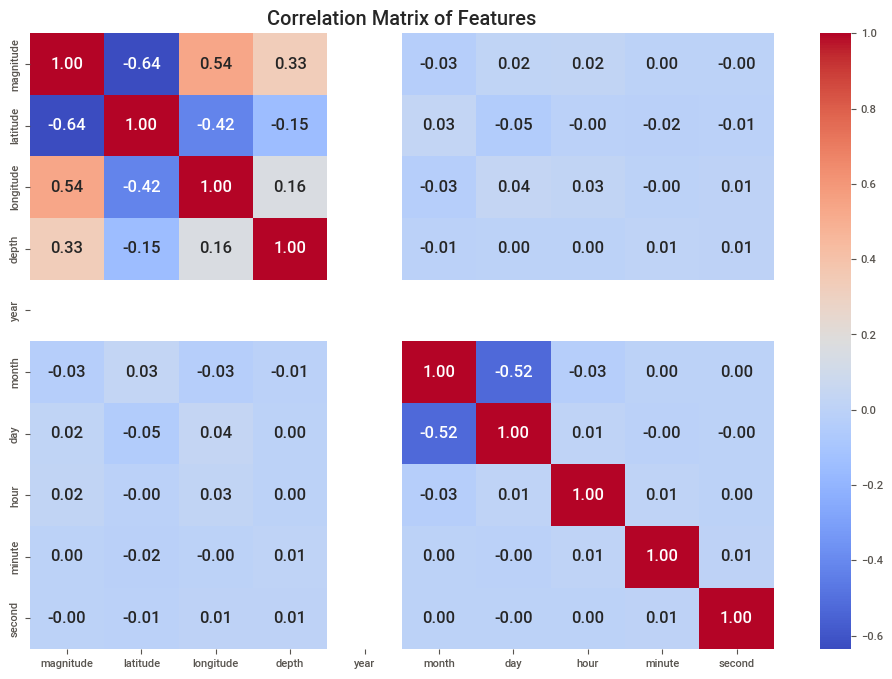

In [24]:
create_visualization(df, 'correlation', 'correlation_matrix.png')

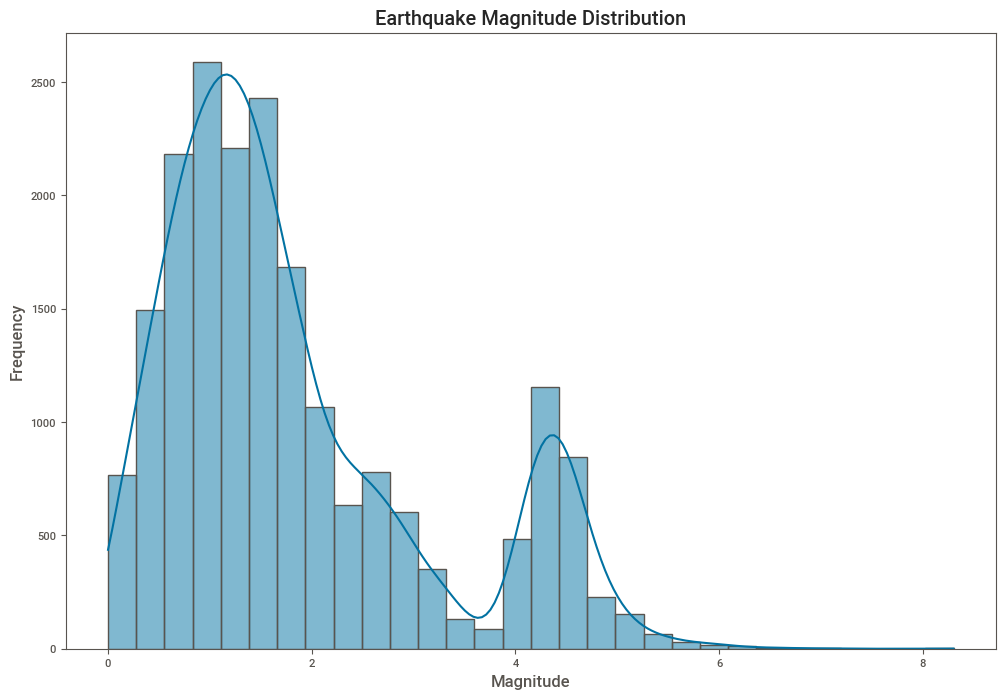

In [25]:
create_visualization(df, 'magnitude_dist', 'magnitude_distribution.png')

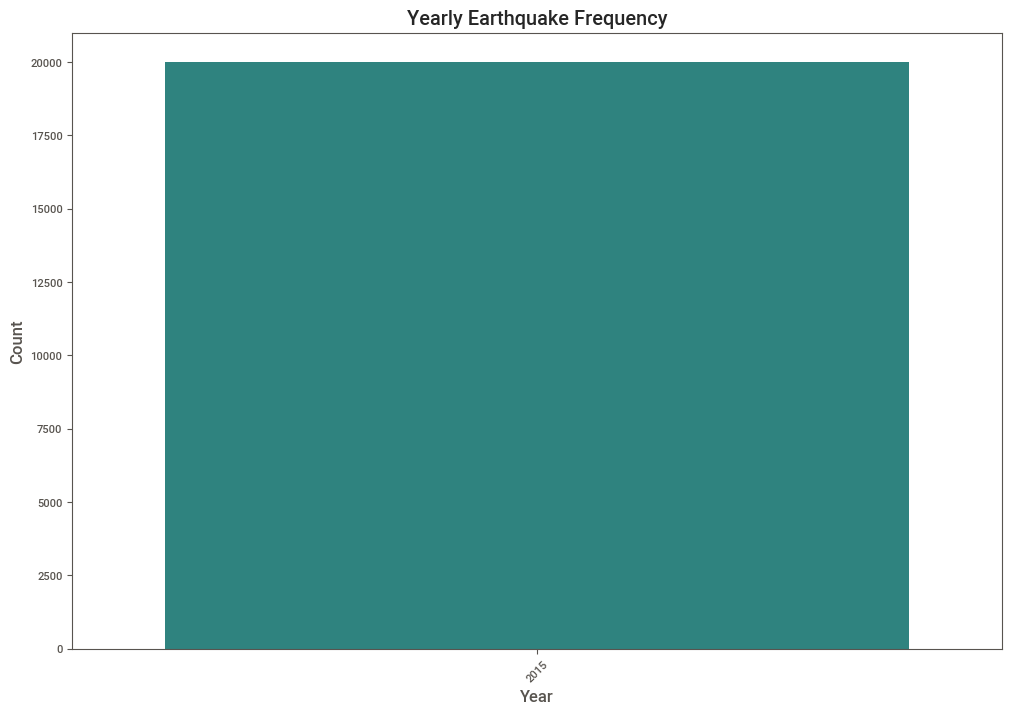

In [26]:
create_visualization(df, 'yearly_count', 'yearly_frequency.png')